In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import recall_score

import matplotlib.pyplot as plt

import joblib

# 1. Read Dataset

In [2]:
data_dir = ""

In [ ]:
df_train = pd.read_csv(data_dir + "train_df.csv")

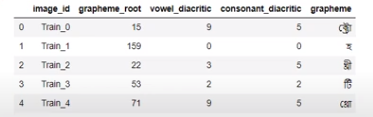

# 2.splits Dataset

In [ ]:
df_train['fold'] = pd.read_csv(data_dir + "df_folds.csv")["fold"]

In [ ]:
trn_fold = [i for i in range(5) if i not in [5]]
vid_fold = [5]

trn_idx = df_train.loc[df_train["fold"].isin(trn_fold)].index
vid_idx = df_train.loc[df_train["fold"].isin(vid_fold)].index

# 3. Define Dataset

In [3]:
class BengaliDataset(Dataset):
  def __init__(self, csv, img_height, img_width, transform):
    self.csv = csv.reset_index()
    self.img_ids = csv["image_id"].values
    self.img_height = img_height
    self.img_width = img_width
    self.transform = transform

  def __len__(self):
    return len(self.csv)

  def __getitem__(self, index):
    img_id = self.img_ids[index]
    img = joblib.load(f"{data_dir}/{img_id}.pkl")

    img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
    img = 255 - img

    img = img[:, :, np.newaxis]
    img = np.repeat(img, 3, 2)

    if self.transform is not None:
      img = self.transform(image=img)["image"]
    
    label_1 = self.csv.iloc[index].grapheme_root
    label_2 = self.csv.iloc[index].vowel_diacritic
    label_3 = self.csv.iloc[index].consonant_diacritic
        
    return img, np.array([label_1, label_2, label_3])

# 4.Define Augmentations

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensor

In [ ]:
# Declare an augmentation pipeline
train_augmentation = A.Compose([
    A.Rotate(20),
    A.RandomRotate90(),
    A.HueSaturationValue(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.OneOf([A.MotionBlur(p=0.2),
    A.MedianBlur(blur_limit=3, p=0.1)], p=0.2), 
    ToTensor()
])

valid_augmentation = A.Compose([
   ToTensor()
])

# 5.Make Dataloader

In [ ]:
trn_dataset = BengaliDataset(csv=df_train.loc[trn_idx], img_height=137, img_width=236, transform=train_augmentation)
vld_dataset = BengaliDataset(csv=df_train.loc[vid_idx], img_height=137, img_width=236, transform=valid_augmentation)

In [ ]:
trn_dataset[0][0]

In [ ]:
trn_loader = DataLoader(trn_dataset, 
                        shuffle=True,
                        num_workers=4,
                        batch_size=256
                        )

vid_loader = DataLoader(vid_dataset,
                        shuffle=False,
                        num_workers=4,
                        batch_size=256
                        )

In [ ]:
# dataloader가 잘 돌아가는지 확인
for inputs, targets in trn_loader:
  break

inputs.shape # [batch_size, channel, width, height]
targets.shape # [batch_size, target_nums]

# 6. Make Model, Optimizerm Criterion

In [ ]:
import pretrainedmodels

In [ ]:
model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

model

In [ ]:
in_features = model.kast_linear.in_features
model.last_linear = torch.nn.Linear(in_features, 186)

In [ ]:
model = model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, model='max',verbose=True, patience=7, factor=0.5)

# 7.trainig

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
train_loss = []
model.train()

In [ ]:
for inputs, targets in trn_dataset:
  break

In [ ]:
inputs = inputs.cuda()
targets = targets.cuda()

In [ ]:
logits = model(inputs)